# Credit Risk Assessment: LightGBM Model Tuning

---

### Import Libraries and set Configurations

In [13]:
import warnings, json, joblib, optuna, lightgbm as lgb
from pathlib import Path
from datetime import date
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import (
    roc_auc_score, average_precision_score, confusion_matrix,
    precision_recall_curve, RocCurveDisplay, classification_report, PrecisionRecallDisplay,
    precision_score, recall_score, f1_score, roc_curve
)
from sklearn.calibration import CalibratedClassifierCV
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")
data = Path("../data/processed")
random_state=42
stamp = date.today().isoformat()
models = Path("../models")
reports = Path("../reports")
processed = Path("../data/processed")
figs = Path("../reports/figs")

### Load Data

In [2]:
df = pd.read_parquet("../data/processed/lc_cleaned.parquet")
schema = json.load(open("../data/processed/feature_schema.json"))
X_train = pd.read_pickle(processed/"X_train.pkl")
X_val = pd.read_pickle(processed/"X_val.pkl")
X_test = pd.read_pickle(processed/"X_test.pkl")
y_train = pd.read_csv(processed/"y_train.csv").squeeze("columns").astype(int)
y_val = pd.read_csv(processed/"y_val.csv").squeeze("columns").astype(int)
y_test= pd.read_csv(processed/"y_test.csv").squeeze("columns").astype(int)
print("train", X_train.shape, "val", X_val.shape, 'test', X_test.shape)

train (1132562, 186) val (181728, 186) test (68061, 186)


### Preprocessing

In [3]:
dt_cols = X_train.select_dtypes("datetime64[ns]").columns          
X_train = X_train.drop(columns=dt_cols)
X_val = X_val.drop(columns=dt_cols)
X_test= X_test.drop(columns=dt_cols)

cat_feats = X_train.select_dtypes("category").columns.tolist()
feature_list = X_train.columns.tolist()
pd.Series(feature_list).to_csv(models / "lgbm_feature_order.csv", index=False)
print("LGBM feature order:", feature_list)
print("LGBM train shape:", X_train.shape)
print("LGBM validation shape:", X_val.shape)
print("LGBM test shape:", X_test.shape)

LGBM feature order: ['loan_amnt', 'funded_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'purpose', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'application_type', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_

### Metrics

In [4]:
def ks_score(y, p): return ks_2samp(p[y==0], p[y==1]).statistic
def profit_curve(y, p, gain_tp=.80, cost_fp=.10):
    prec, rec, thr = precision_recall_curve(y, p)
    tp = rec*y.sum(); fp = (tp/np.clip(prec,1e-9,1))-tp
    prof = (gain_tp*tp - cost_fp*fp)/len(y)
    idx = prof.argmax(); return float(thr[idx]), float(prof[idx])
def best_f1(y,p):
    prec, rec, thr = precision_recall_curve(y,p)
    f1 = 2*prec*rec/(prec+rec+1e-12); return float(thr[f1.argmax()])
def metrics(y, p, thr):
    ŷ = (p>thr).astype(int)
    return dict(AUC=roc_auc_score(y,p),
                PR_AUC=average_precision_score(y,p),
                KS=ks_score(y,p),
                Precision=precision_score(y,ŷ),
                Recall=recall_score(y,ŷ),
                ConfMatrix=confusion_matrix(y,ŷ).tolist(),
                ClassReport=classification_report(y,ŷ,digits=3,zero_division=0))

### Monotonic Constraints

In [9]:
feature_list = X_train.columns.tolist()
monotone = False       
if monotone:
    monotone_map = {
        "fico_mid": 1,
        "loan_to_income": -1,
        "installment_to_income": -1,
        "dti": -1,
        "int_rate": -1,
        "credit_age_months": 1
    }
    mono_vec = [monotone_map.get(f, 0) for f in feature_list]
else:
    mono_vec = [0] * len(feature_list)      

assert len(mono_vec) == len(feature_list), "Monotone vector length mismatch"

### Tune LightGBM Model

In [17]:
model_version = "v1"
lgbm_path = models / f"lgbm_calibrated_{model_version}.joblib"
params_path = models / f"params_lightgbm_{model_version}.json"
study_pkl = models / "optuna_lgbm_v1.pkl"
max_trials=200

def checkpoint(study, trial):
        if trial.number % 2 == 0:
            study_pkl.parent.mkdir(parents=True, exist_ok=True)
            joblib.dump(study, study_pkl)
            print(f"checkpoint saved at trial {trial.number}")

if study_pkl.exists():
    study = joblib.load(study_pkl)
    print(f"Resuming study – {len(study.trials)} trials loaded")
    if len(study.trials) >= max_trials:
        print(f"Study complete ({len(study.trials)} trials).")
        run_tuning = False
    else:
        run_tuning = True
elif lgbm_path.exists():
    print("Using cached LightGBM:", lgbm_path.name)
    cal = joblib.load(lgbm_path)
    run_tuning = False
else:
    study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=random_state, multivariate=True),
    pruner =optuna.pruners.MedianPruner(n_warmup_steps=10)
    )
    study.enqueue_trial({
        "learning_rate":0.05, "num_leaves":31, "max_depth":-1,
        "min_child_samples":200, "min_child_weight":1e-3,
        "feature_fraction":0.9, "bagging_fraction":0.9,"bagging_freq":1,
        "reg_alpha":1e-3,"reg_lambda":1e-3, "scale_pos_weight": (y_train==0).sum()/(y_train==1).sum()
    })
    print("New study created")
    run_tuning = True

if run_tuning:
    tscv_inner = TimeSeriesSplit(n_splits=3)
    def objective(trial):
        params = {
            "objective" :"binary",
            "metric": "auc",
            "boosting_type": "gbdt",
            "verbosity": -1, 
            "learning_rate":trial.suggest_float("learning_rate", 0.02, 0.07, log=True),
            "num_leaves":trial.suggest_int("num_leaves", 31, 1023, log=True),
            "max_depth": trial.suggest_categorical("max_depth", [-1, 7, 9, 11]),
            "min_child_samples": trial.suggest_int("min_child_samples", 50, 400),
            "min_child_weight": trial.suggest_float("min_child_weight", 1e-3, 10.0, log=True), 
            "min_gain_to_split": trial.suggest_float("min_gain_to_split", 1e-4, 0.05, log=True),
            "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 10.0, log=True),
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True),
            "feature_fraction": trial.suggest_float("feature_fraction", 0.7, 1.0),
            "bagging_fraction": trial.suggest_float("bagging_fraction", 0.7, 1.0),
            "bagging_freq": trial.suggest_int("bagging_freq", 1, 6),      
            "monotone_constraints": mono_vec,
            "force_col_wise":True,
            "max_cat_threshold": 64,
            "random_state":random_state,
            "scale_pos_weight": (y_train==0).sum()/(y_train==1).sum(),
            "n_jobs": -1,
            "n_estimators": 4000          
        }    
        aucs=[]
        for tr, va in tscv_inner.split(X_train, y_train):
            model = lgb.LGBMClassifier(**params)
            model.fit(
                X_train.iloc[tr], y_train.iloc[tr],
                eval_set=[(X_train.iloc[va], y_train.iloc[va])],
                eval_metric="auc",
                categorical_feature=cat_feats,
                callbacks=[lgb.early_stopping(200, verbose=False)])
            preds = model.predict_proba(X_train.iloc[va])[:, 1]
            aucs.append(roc_auc_score(y_train.iloc[va], preds))

        return float(np.mean(aucs))
    
    try:
        study.optimize(objective, n_trials=200, n_jobs=1, timeout=8*3600, callbacks=[checkpoint], show_progress_bar=True)
    finally:
        joblib.dump(study, study_pkl)
    print("Best AUC so far:", study.best_value, "after", len(study.trials), "trials")
    best_params = study.best_params | {
    "objective":"binary", "metric":"auc", "force_col_wise":True,
    "max_cat_threshold": 64,"monotone_constraints": mono_vec,
    "scale_pos_weight": (y_train==0).sum()/(y_train==1).sum(),
    "seed": random_state
    }
    lgbm = lgb.LGBMClassifier(**best_params)
    
    lgbm.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric="auc",
        categorical_feature=cat_feats,
        callbacks=[lgb.early_stopping(200, verbose=False)]
    )

    cal = CalibratedClassifierCV(lgbm, method="sigmoid", cv="prefit").fit(X_val, y_val)
    joblib.dump(cal, lgbm_path)
    with open(params_path,"w") as fp: json.dump(best_params, fp, indent=2)
    pd.DataFrame({'feature': feature_list, 'monotonicity': mono_vec}).to_csv(models / f"monotonic_constraints_{model_version}.csv", index=False)
    study.trials_dataframe().to_csv(models / f"optuna_trials_lightgbm_{model_version}.csv", index=False)

Resuming study – 202 trials loaded
Study complete (202 trials).


### Model Evaluation - Train/Test

In [16]:
p_train = cal.predict_proba(X_train)[:,1]
p_val = cal.predict_proba(X_val)[:,1]

thr_profit_val,_ = profit_curve(y_val,p_val)
thr_f1_val = best_f1(y_val,p_val)
thr_f1_train = best_f1(y_train,p_train)

m_train = metrics(y_train,p_train,thr_f1_train)
m_val_p = metrics(y_val,p_val,thr_profit_val)
m_val_f = metrics(y_val,p_val,thr_f1_val)

md_path = reports / f"metrics_lgbm_trainval_{model_version}.md"
with open(md_path, "w") as f:
    f.write(f"# LightGBM – {model_version}\n")
    f.write(f"*Date generated:* {date.today().isoformat()}\n\n")

    # ----------- thresholds ---------------------------------------
    f.write("## Thresholds chosen\n")
    f.write("| Split | F1-opt | Profit-opt |\n")
    f.write("|-------|-------:|-----------:|\n")
    f.write(f"| Train | {thr_f1_train:.3f} | – |\n")
    f.write(f"| Val   | {thr_f1_val:.3f} | {thr_profit_val:.3f} |\n\n")

    # ----------- TRAIN (F1-optimised) -----------------------------
    f.write("## Train (F1-optimised)\n")
    f.write(f"- **AUC:** `{m_train['AUC']:.4f}`  \n")
    f.write(f"- **PR-AUC:** `{m_train['PR_AUC']:.4f}`  \n")
    f.write(f"- **KS:** `{m_train['KS']:.4f}`  \n\n")
    f.write("```text\n" + m_train["ClassReport"] + "\n```\n\n")

    # ----------- VALIDATION – F1 ----------------------------------
    f.write("## Validation (F1-optimised)\n")
    f.write(f"- **AUC:** `{m_val_f['AUC']:.4f}`  \n")
    f.write(f"- **PR-AUC:** `{m_val_f['PR_AUC']:.4f}`  \n")
    f.write(f"- **KS:** `{m_val_f['KS']:.4f}`  \n\n")
    f.write("```text\n" + m_val_f["ClassReport"] + "\n```\n\n")

    # ----------- VALIDATION – Profit ------------------------------
    f.write("## Validation (Profit-optimised)\n")
    f.write(f"- **AUC:** `{m_val_p['AUC']:.4f}`  \n")
    f.write(f"- **PR-AUC:** `{m_val_p['PR_AUC']:.4f}`  \n")
    f.write(f"- **KS:** `{m_val_p['KS']:.4f}`  \n\n")
    f.write("```text\n" + m_val_p["ClassReport"] + "\n```\n")

print("Markdown metrics written to", md_path.relative_to(reports))

print("=== TRAIN (F1-opt) ===\n",m_train["ClassReport"])
print("\n=== VALID (profit-opt) ===\n",m_val_p["ClassReport"])
print("\n=== VALID (F1-opt) ===\n",m_val_f["ClassReport"])

Markdown metrics written to metrics_lgbm_trainval_v1.md
=== TRAIN (F1-opt) ===
               precision    recall  f1-score   support

           0      0.879     0.725     0.794    901143
           1      0.363     0.611     0.456    231419

    accuracy                          0.702   1132562
   macro avg      0.621     0.668     0.625   1132562
weighted avg      0.774     0.702     0.725   1132562


=== VALID (profit-opt) ===
               precision    recall  f1-score   support

           0      0.935     0.218     0.354    130152
           1      0.328     0.962     0.489     51576

    accuracy                          0.429    181728
   macro avg      0.632     0.590     0.421    181728
weighted avg      0.763     0.429     0.392    181728


=== VALID (F1-opt) ===
               precision    recall  f1-score   support

           0      0.843     0.746     0.792    130152
           1      0.503     0.650     0.568     51576

    accuracy                          0.719    1

### Model Evaluation - Test


=== TEST (profit-opt) ===
               precision    recall  f1-score   support

           0      0.936     0.409     0.569     47444
           1      0.407     0.935     0.568     20617

    accuracy                          0.568     68061
   macro avg      0.671     0.672     0.568     68061
weighted avg      0.776     0.568     0.569     68061


=== TEST (F1-opt) ===
               precision    recall  f1-score   support

           0      0.851     0.976     0.909     47444
           1      0.916     0.606     0.729     20617

    accuracy                          0.864     68061
   macro avg      0.884     0.791     0.819     68061
weighted avg      0.871     0.864     0.855     68061

ROC, PR, KS, and Profit curves saved
Markdown metrics written to metrics_lgbm_test_v1.md


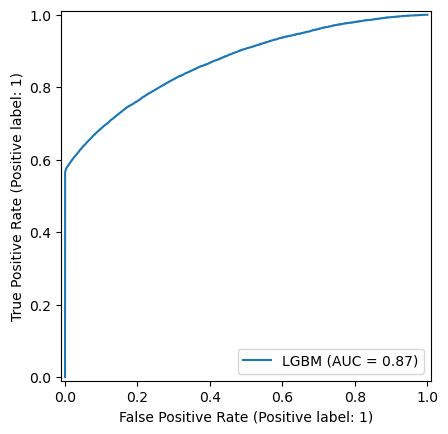

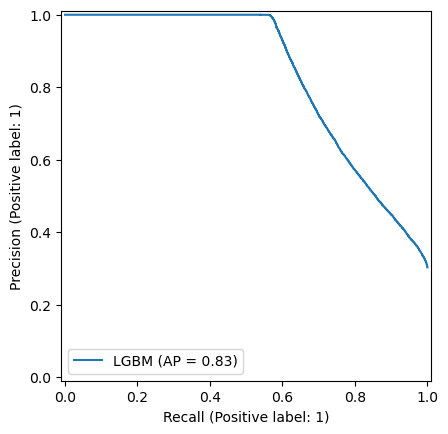

In [20]:
if __name__ == "__main__":
    p_test = cal.predict_proba(X_test)[:,1]
    thr_profit_test,_ = profit_curve(y_test,p_test)
    thr_f1_test = best_f1(y_test,p_test)

    m_test_p = metrics(y_test,p_test,thr_profit_test)
    m_test_f = metrics(y_test,p_test,thr_f1_test)

    print("\n=== TEST (profit-opt) ===\n",m_test_p["ClassReport"])
    print("\n=== TEST (F1-opt) ===\n",m_test_f["ClassReport"])

    RocCurveDisplay.from_predictions(y_test,p_test,name="LGBM").figure_.savefig(figs/f"roc_lgbm_test_{model_version}.png",dpi=300)
    PrecisionRecallDisplay.from_predictions(y_test,p_test,name="LGBM").figure_.savefig(figs/f"pr_lgbm_test_{model_version}.png",dpi=300)
    fpr, tpr, thr_roc = roc_curve(y_test, p_test)
    ks = tpr - fpr
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(thr_roc, tpr, label="TPR")
    ax.plot(thr_roc, fpr, label="FPR")
    ax.plot(thr_roc, ks,  label=f"KS = {ks.max():.3f}")
    ax.set_xlabel("Threshold"); ax.set_ylabel("Rate")
    ax.set_title("KS Chart")
    ax.legend()
    fig.tight_layout()
    fig.savefig(figs / f"ks_lgbm_test_{model_version}.png", dpi=300)
    plt.close(fig)

    md_path = reports / f"metrics_lgbm_test_{model_version}.md"
    with open(md_path, "w") as f:
        f.write(f"# LightGBM – Test metrics ({model_version})\n")
        f.write(f"*Date generated:* {date.today().isoformat()}\n\n")

        f.write("## Thresholds\n")
        f.write("| Optimisation | Threshold |\n")
        f.write("|--------------|-----------:|\n")
        f.write(f"| F1           | {thr_f1_test:.3f} |\n")
        f.write(f"| Profit       | {thr_profit_test:.3f} |\n\n")

        # F1-optimised block
        f.write("### Test (F1-optimised)\n")
        f.write(f"- **AUC:** `{m_test_f['AUC']:.4f}`  \n")
        f.write(f"- **PR-AUC:** `{m_test_f['PR_AUC']:.4f}`  \n")
        f.write(f"- **KS:** `{m_test_f['KS']:.4f}`  \n\n")
        f.write("```text\n" + m_test_f["ClassReport"] + "\n```\n\n")

        # Profit-optimised block
        f.write("### Test (Profit-optimised)\n")
        f.write(f"- **AUC:** `{m_test_p['AUC']:.4f}`  \n")
        f.write(f"- **PR-AUC:** `{m_test_p['PR_AUC']:.4f}`  \n")
        f.write(f"- **KS:** `{m_test_p['KS']:.4f}`  \n\n")
        f.write("```text\n" + m_test_p["ClassReport"] + "\n```\n")

    print("ROC, PR, KS, and Profit curves saved")
    print("Markdown metrics written to", md_path.relative_to(reports))
